# Characterising the evolution of the user interests on YT

This notebook covers the whole pipeline of the project.

Here is the table content of the principal tasks : 
- **Data Processing**
- **Preparing Pyspark Model**
- **Topic modelling**
- **Results: Topic Coherence**
- **Classifier**


### 0.1 Imports

In [1]:
import collections
import fasttext
import gzip
import json
import nltk
import os
import pickle
import scipy.sparse
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zstandard as zstd

from collections import Counter
from gensim.models.coherencemodel import CoherenceModel
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import LongType, StructField, StructType
from pyspark.ml.clustering import LDA, LDAModel, LocalLDAModel
from pyspark.ml.linalg import Vectors, SparseVector
from scipy.sparse import dok_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/olam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1 Data Processing 

In this section, we will select the data for the topic modelling model as follow:

- videos has at least 10'000 views
- videos from channels with at least 100'000 subscribers

For that, we proceed as follow :

- first pass over the whole dataset in order to build the vocabulary and the keep the index of the relevant videos
- second pass over the whole dataset to construct a NxM sparse matrix, where N is the number of videos and M is the number of words in the vocabulary

In [2]:
# GET THE LIST OF RELEVANT CHANNELS

df_channelcrawler = pd.read_csv('/dlabdata1/youtube_large/channelcrawler.csv')

df_channelcrawler['channel_id'] = df_channelcrawler['link'].apply(
    lambda x: x.replace('http://www.youtube.com/channel/', ''))

# Filter channels with at least 100'000 subs
df_channelcrawler = df_channelcrawler[df_channelcrawler['subscribers'] >= 100000]

# Store in a set since it will be faster to check if a channel is in channelcrawler
set_relevant_channels = set(df_channelcrawler['channel_id'])

print('There are ' + str(len(set_relevant_channels)) + ' relevant channels.')

There are 50456 relevant channels.


In [26]:
# Setting NLP pre-processing features
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
s_stemmer = SnowballStemmer(language='english')

In [3]:
def check_10000_views(video):
    try:
        view_counts = video['view_count']
        if view_counts != None:
            return view_counts >= 10000
        else:
            return False
    except KeyError:
        return False

In [4]:
def check_channel(video, set_relevant_channels):
    try:
        return video['channel_id'] in set_relevant_channels
    except:
        return False

In [5]:
def isEnglishAlpha(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [6]:
def get_freq_tokens_per_video(video):
    ''''''

    title_tokens = [w for w in tokenizer.tokenize(
        video['title'].lower()) if not w in stop_words]
    tag_tokens = [w for w in tokenizer.tokenize(
        video['tags'].lower()) if not w in stop_words]

    # We want to keep duplicates !!
    tokens_per_video = title_tokens + tag_tokens

    # Filter token with length < 3, with non english alphabet since fastext is not 100% accurate and remove numerical token
    tokens_keep = []
    for token in tokens_per_video:
        if len(token) >= 3 and (not token.isnumeric()) and isEnglishAlpha(token):
            tokens_keep.append(token)

    # Stemming
    stemmed_tokens_per_video = ([s_stemmer.stem(w) for w in tokens_keep])

    # Return a Counter object of the tokens
    return collections.Counter(stemmed_tokens_per_video)

### 1.1 First pass 
The first pass on the dataset will allow us to recover relevant videos and list of tokens

In [12]:
# Variable that contains the idx of every non english vid and that
# belongs to a channel in channelcrawler.csv TO BE USED IN SECOND ITER
set_relevant_vid = set()

# Variable first instanciated as set to check existing tokens efficiently,
# which will be a list in order to get the index for each tokens
set_stemmed_tokens = set()

i = 0

for filepath in os.listdir('/dlabdata1/youtube_large/yt_metadata_en_dd/'):
    
    # Reading the file
    with gzip.open('/dlabdata1/youtube_large/yt_metadata_en_dd/' + filepath, 'rb') as f:

        for line in f:

            # line is a byte dict, video is the corresponding dict
            video = json.loads(line)

            if check_channel(video, set_relevant_channels) and check_10000_views(video):

                tokens_per_video = get_freq_tokens_per_video(video)

                set_relevant_vid.add(i)
                set_stemmed_tokens.update(tokens_per_video)

            if i % 10000000 == 0 and i != 0:
                print('Processed ' + str(i) + ' videos...')
                
            i += 1

Processed 10000000 videos...
Processed 20000000 videos...
Processed 30000000 videos...
Processed 40000000 videos...
Processed 50000000 videos...
Processed 60000000 videos...
Processed 70000000 videos...


In [13]:
# save some intermediate results

with open('/dlabdata1/youtube_large/olam/data/final_res/set_relevant_vid.pickle', 'wb') as f:
    pickle.dump(set_relevant_vid, f)
f.close()

with open('/dlabdata1/youtube_large/olam/data/final_res/set_stemmed_tokens.pickle', 'wb') as f:
    pickle.dump(set_stemmed_tokens, f)
f.close()

with open('/dlabdata1/youtube_large/olam/data/final_res/set_relevant_channels.pickle', 'wb') as f:
    pickle.dump(set_relevant_channels, f)
f.close()

### 1.2 Second pass 
The second pass on the dataset will allow us to create a NxM sparse matrix, where N is the number of videos and M is the number of words in the vocabulary

Notes:
- In order to keep the memory usage low, we will fill sparse matrix with only 1'000'000 rows and save them in the csr format
- Stack the saved sparse matrix together to get the final sparse matrix

In [7]:
def remove_zero_rows(M):
    '''Function that removes all rows from sparse matrix M that contains only zero.'''
    num_nonzeros = np.diff(M.indptr)
    return M[num_nonzeros != 0]

In [8]:
def fill_underlying_dict(freq_tokens_per_video, word2id, i_vid):
    '''Method to fill the underlying dictionnary in order to 
    update the sparse matrix incrementally by videos'''

    dict_freq_tokens_for_sparse_matrix = {}

    for key in freq_tokens_per_video.keys():

        # Column index in the sparse matrix (one column for each token)
        try:
            j_token = word2id[key]

            # Filling the underlying dict
            dict_freq_tokens_for_sparse_matrix[(
                i_vid % 1000000,   j_token)] = freq_tokens_per_video[key]

        except KeyError:
            None

    return dict_freq_tokens_for_sparse_matrix

In [16]:
# Get dimension of sparse matrix
size_of_tokens_dict = len(set_stemmed_tokens)
number_of_vid = len(set_relevant_vid)

# Create dictionnary of tokens with their indice
word2id = {}

# Fill dictionnary of tokens
for i, token in enumerate(set_stemmed_tokens):
    word2id[token] = i
    
id2word = {v: k for k, v in word2id.items()}

# Create mini sparse matrix
S = dok_matrix((1000000, size_of_tokens_dict), dtype=np.uint8)

In [23]:
i_vid = 0
i = 0

for filepath in os.listdir('/dlabdata1/youtube_large/yt_metadata_en_dd/'):
    
    # Reading the file
    with gzip.open('/dlabdata1/youtube_large/yt_metadata_en_dd/' + filepath, 'rb') as f:

        for line in f:

            if i_vid % 1000000 == 0 and i_vid != 0:

                file_name = 'S' + str(int(i_vid/1000000)) + '.npz'

                if not os.path.isfile('/dlabdata1/youtube_large/olam/data/final_res/matrices/' + file_name):

                    # Transform to csr format for memory efficiency
                    S = S.tocsr()
                    scipy.sparse.save_npz(
                        '/dlabdata1/youtube_large/olam/data/final_res/matrices/' + file_name, S)

                    # Refresh mini sparse matrix
                    S = dok_matrix((1000000, size_of_tokens_dict), dtype=np.uint8)

            if i in set_relevant_vid:

                video = json.loads(line)

                # Get the tokens for each video and theirs number of occurences
                freq_tokens_per_video = get_freq_tokens_per_video(video)

                # Fill the underlying dict
                dict_freq_tokens_for_sparse_matrix = fill_underlying_dict(
                    freq_tokens_per_video, word2id, i_vid)

                # Fill data in to sparse matrix
                dict.update(S, dict_freq_tokens_for_sparse_matrix)

                # Increase i_vid
                i_vid += 1

            if i % 10000000 == 0 and i != 0:
                print('Processed ' + str(i) + ' videos...')
                
            i += 1

# Save last sparse matrix
S = S.tocsr()
scipy.sparse.save_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/S_last.npz', S)

Processed 10000000 videos...
Processed 20000000 videos...
Processed 30000000 videos...
Processed 40000000 videos...
Processed 50000000 videos...
Processed 60000000 videos...
Processed 70000000 videos...


In [25]:
# Get final sparse matrix
S = scipy.sparse.load_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/S1.npz')

for i in range(2, 17):
    S_next = scipy.sparse.load_npz(
        '/dlabdata1/youtube_large/olam/data/final_res/matrices/S' + str(i) + '.npz')
    S = scipy.sparse.vstack([S, S_next])

# Add last matrix
S_last = scipy.sparse.load_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/S_last.npz')
S = scipy.sparse.vstack([S, S_last])

In [26]:
# save the full matrix
scipy.sparse.save_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/S_full.npz', S)

## 2 Process the data for Topic Modelling with PySpark

First, for a better topic modelling model, we select the videos from the sparse matrix as follow:
- we group the videos by their respective `channel_id`, `category` and `upload_date`
- keep the 20 videos with the most `view_counts` from each group
- keep tokens that appears in at least 100 videos

Then, we should compute a spark dataframe from our final sparse matrix in order to compute the models on the hadoop cluster

### 2.1 Filter the videos for topic modelling 

In [28]:
# create pandas DataFrame of relevant videos with relevant features
columns_names = ['channel_id',
                 'view_counts', 'uploaded_year', 'category']

# store relevant features of relevant videos in a list
list_relevant_data = []

i = 0

for filepath in os.listdir('/dlabdata1/youtube_large/yt_metadata_en_dd/'):
    
    # Reading the file
    with gzip.open('/dlabdata1/youtube_large/yt_metadata_en_dd/' + filepath, 'rb') as f:

        for line in f:
            if i % 10000000 == 0 and i != 0:
                print('Progress: ' + str(int(i/10000000)) + '/7')

            if i in set_relevant_vid:

                # line is a str dict, video is the dict corresponding to the str dict
                video = json.loads(line)

                list_vid_relevant_features = [video['channel_id']]
                list_vid_relevant_features.append(video['view_count'])
                list_vid_relevant_features.append(video['upload_date'][:4])
                list_vid_relevant_features.append(video['categories'])

                list_relevant_data.append(list_vid_relevant_features)
                
            i += 1

Progress: 1/7
Progress: 2/7
Progress: 3/7
Progress: 4/7
Progress: 5/7
Progress: 6/7
Progress: 7/7


In [29]:
df_relevant_data = pd.DataFrame(list_relevant_data, columns=columns_names)
df_relevant_data_top20 = df_relevant_data.sort_values(['view_counts'], ascending=False).groupby(
    ['category', 'uploaded_year', 'channel_id']).head(20)

set_relevant_vid_top20 = sorted(df_relevant_data_top20.index.values)

In [30]:
# Save intermediate result
with open('/dlabdata1/youtube_large/olam/data/final_res/model/set_relevant_vid_top20.pickle', 'wb') as f:
    pickle.dump(set_relevant_vid_top20, f)
f.close()

### 2.2 Keep only relevant tokens

In [ ]:
# Load intermediate data
S = scipy.sparse.load_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/S_full.npz')


# Load set of videos in the top20 as processed abose
with open('/dlabdata1/youtube_large/olam/data/final_res/model/set_relevant_vid_top20.pickle', 'rb') as f:
    set_relevant_vid_top20 = pickle.load(f)
f.close()

In [31]:
S = S[set_relevant_vid_top20]

# Convert matrix to csc for efficient computing
S = S.tocsc()

list_relevant_tokens = []

# Iterate on the columns
for i in range(S.shape[1]):

    if i % 1000000 == 0:
        print('Processed : ' + str(i) + ' tokens')

    # Check column has more than 100 non zero entries
    if S[:, i].count_nonzero() >= 100:
        list_relevant_tokens.append(i)

Processed : 0 tokens
Processed : 1000000 tokens
Processed : 2000000 tokens


In [32]:
S = S[:, list_relevant_tokens].tocsr()
S = remove_zero_rows(S)

scipy.sparse.save_npz('/dlabdata1/youtube_large/olam/data/final_res/matrices/S_final.npz', S)

### 2.3 Build a dictionnary id2word for final sparse matrix

`id2word_top20` is a dictionnary that map each of the token id to the token itself only for relevant tokens for top20 data

In [33]:
id2word_top20 = {}

for i, id_token in enumerate(list_relevant_tokens):
    id2word_top20[i] = id2word[id_token]

In [34]:
# Save intermediate result
with open('/dlabdata1/youtube_large/olam/data/final_res/id2word_top20.pickle', 'wb') as f:
    pickle.dump(id2word_top20, f)
f.close()

### 2.4 Get Spark dataframe to use the hadoop cluster to perform topic modelling

In [35]:
conf = SparkConf().setMaster("local").setAll(
    [('spark.executor.memory', '4g'), ('spark.driver.memory', '16g'), ('spark.driver.maxResultSize', '0')])

# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [10]:
def get_dict_for_row(row, S):
    '''Construct SparseVector bag-of-word for each row (videos)'''
    tmp_dict = {}
    for key, value in row:
        tmp_dict[key[1]] = value

    return SparseVector(S.shape[1], tmp_dict)

In [37]:
data = []

print('Process video for topic modelling...')
for i in range(S.shape[0]):

    if i % 1000000 == 0:
        print(str(i) + ' videos processed...')

    data.append([i, get_dict_for_row(S.getrow(i).todok().items(), S)])


# Construct dataframe for LDA
all_df = spark.createDataFrame(data, ["id", "features"])

Process video for topic modelling...
0 videos processed...
1000000 videos processed...
2000000 videos processed...
3000000 videos processed...


In [38]:
# save the dataframe
all_df.write.option('compression', 'gzip').json(
    '/dlabdata1/youtube_large/olam/data/final_res/model/sparkdf.json')

## 3 Topic Modelling

The python script for topic modelling can be found in the folder `script/yt_lda_tune.py`

In order to run the script on the Hadoop server, the following need to be done:

- copy the file in hdfs: `$ hdfs dfs -put /dlabdata1/youtube_large/olam/data/final_res/model/sparkdf.json /user/olam/final_res/`

- on the Hadoop server, go to the script folder and launch the following command: `$ sspark-submit --master yarn --deploy-mode cluster --num-executors 47 --executor-cores 4 --driver-memory 64g --executor-memory 4g yt_lda_tune.py`

- get the resulting files in hdfs: `$ hdfs dfs -get /user/olam/final_res/tune/ /dlabdata1/youtube_large/olam/data/final_res/model/tune/`

## 4 Results: Topic Coherence

In order to choose the number of topic for the final TP model (where TP model means Topic Modelling model), we will compute the coherence scores for each model trained, as described in Section 3.

The coherence scores that are used are the following:
- `c_v`: based on a sliding window, a one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosinus similarity.
- `u_mass`: based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure.

As suggested in the litterature in http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf, the higher the 'c_v' score is the better the model is and the nearer the 'u_mass' score is to 0, the better the model is (the 'u_mass' score scales from -14 to 14 )



In [9]:
class FakedGensimDict:
    """
    Locally made class for `~gensim.corpora.dictionary.Dictionary`
    """

    def __init__(self, data, S):
        if not isinstance(data, dict):
            raise ValueError('`data` must be an instance of `dict`')

        self.id2token = data
        self.token2id = {v: k for k, v in data.items()}
        self.doc2bow = S

    @staticmethod
    def from_vocab(vocab):
        return FakedGensimDict(dict(zip(range(len(vocab)), vocab)))

### 4.1 Preparing the coherence model

In [3]:
# Load the intermediate results

S = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/final_res/matrices/S_final.npz')

with open('/dlabdata1/youtube_large/olam/data/final_res/id2word_top20.pickle', 'rb') as f:
    id2word_top20 = pickle.load(f)
f.close()

In [4]:
texts = []

for i in range(S.shape[0]):
    token_indices = list(S.getrow(i).nonzero()[1])
    tokens = []

    for token_indice in token_indices:
        tokens.append(id2word_top20[token_indice])
    texts.append(tokens)

In [5]:
corpus = []

n_batches = 10
batch_size = int(S.shape[0] / n_batches)


for k in range(n_batches - 1):

    for row in S[k * batch_size: (k + 1) * batch_size].toarray():
        bow = []
        idx_nonzero = np.nonzero(row)[0]
        for i in range(len(idx_nonzero)):
            bow.append((idx_nonzero[i], row[idx_nonzero[i]]))
        corpus.append(bow)
        
for row in S[(n_batches - 1) * batch_size:].toarray():
    bow = []
    idx_nonzero = np.nonzero(row)[0]
    for i in range(len(idx_nonzero)):
        bow.append((idx_nonzero[i], row[idx_nonzero[i]]))
    corpus.append(bow)

### 4.2 Get the coherence scores for each model 

In [6]:
conf = SparkConf().setMaster("local")#.setAll([('spark.executor.memory', '10g'),('spark.driver.memory','32g'),('spark.driver.maxResultSize', '0')])

# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [12]:
coherence_scores = []
coherence_scores_umass = []


n_topics_list = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95,
                 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150]

for i, n_topics in enumerate(n_topics_list):

    #print('Computing coherence score for model with ' +
    #      str(n_topics) + ' topics...')

    # Get describe_topics dataframe
    describe_topics = spark.read.json(
        '/dlabdata1/youtube_large/olam/data/final_res/model/describe_topics/describe_topics_' + str(n_topics) + '.json')

    # Characterize the topics with tokens
    topics = []

    for row in describe_topics.sort('topic').rdd.collect():
        tokenized_topic = []
        for j, token_id in enumerate(row.termIndices):
            tokenized_topic.append(id2word_top20[token_id])
            if j > 10:
                break
        topics.append(tokenized_topic)

    # Compute c_v coherence score and append to coherence scores
    coherence_model = CoherenceModel(topics=topics,
                                     corpus=S,
                                     dictionary=FakedGensimDict(
                                         id2word_top20, S),
                                     texts=texts,
                                     coherence='c_v')

    # Compute u_mass coherence score and append to coherence scores
    coherence_model_umass = CoherenceModel(topics=topics,
                                           corpus=corpus,
                                           dictionary=FakedGensimDict(
                                               id2word_top20, S),
                                           coherence='u_mass')

    #print('Getting c_v coherence score...')
    coherence_scores.append(coherence_model.get_coherence())
    #print('Getting u_mass coherence score...')
    coherence_scores_umass.append(coherence_model_umass.get_coherence())

([<matplotlib.axis.XTick at 0x7f30d3320ee0>,
 [Text(0, 0, '50'),
  Text(1, 0, '55'),
  Text(2, 0, '60'),
  Text(3, 0, '65'),
  Text(4, 0, '70'),
  Text(5, 0, '75'),
  Text(6, 0, '80'),
  Text(7, 0, '85'),
  Text(8, 0, '90'),
  Text(9, 0, '95'),
  Text(10, 0, '100'),
  Text(11, 0, '105'),
  Text(12, 0, '110'),
  Text(13, 0, '115'),
  Text(14, 0, '120'),
  Text(15, 0, '125'),
  Text(16, 0, '130'),
  Text(17, 0, '135'),
  Text(18, 0, '140'),
  Text(19, 0, '145'),
  Text(20, 0, '150')])

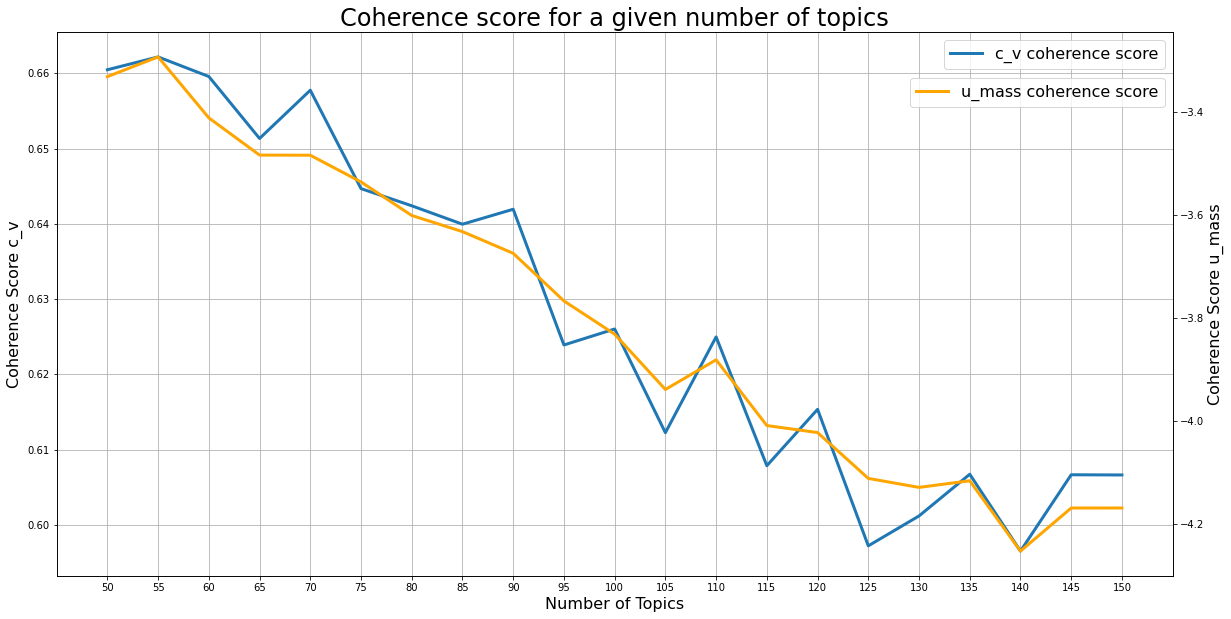

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title('Coherence score for a given number of topics', fontsize=24)
ax.set_xlabel('Number of Topics', fontsize=16)
ax.set_ylabel('Coherence Score c_v', fontsize=16)

ax.grid('on')

ax.plot(coherence_scores, label='c_v coherence score', linewidth=3)

ax2 = ax.twinx()
ax2.set_ylabel('Coherence Score u_mass', fontsize=16)
ax2.plot(coherence_scores_umass, label='u_mass coherence score', linewidth=3, color='orange')

ax.legend(fontsize=16)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.93), fontsize=16)

plt.xticks(np.arange(len(n_topics_list)), n_topics_list)

In [16]:
fig.savefig('/home/olam/coherence_scores_newdata')

## 5 Classifier

#TODO describe the utility of this section

### Filter the data for classification

As we have filtered a specific data in the topic modelling task, we will do the same here. We do not select the data that has been used for topic modelling but we still want to use relevant data. For this, we keep only the videos with more than 10'000 views. 

We will not be able to use the already computed variable as `set_relevant_vid.pickle` or `set_relevant_vid_top20.pickle` since the index are defined for videos with more than 10'000 views from channels with more than 100'000 subs. In this case, we don't want the second condition, we just need the channel to be in the set of the crawled channels.

#### Get the data of the relevant videos for the classifier

In [11]:
# GET THE LIST OF RELEVANT CHANNELS

df_channelcrawler = pd.read_csv('/dlabdata1/youtube_large/channelcrawler.csv')

df_channelcrawler['channel_id'] = df_channelcrawler['link'].apply(
    lambda x: x.replace('http://www.youtube.com/channel/', ''))

# Store in a set since it will be faster to check if a channel is in channelcrawler
set_relevant_channels_classifier = set(df_channelcrawler['channel_id'])

print('There are ' + str(len(set_relevant_channels_classifier)) + ' relevant channels.')

There are 164648 relevant channels.


In [12]:
### Get the relevant features of the relevant videos

array_relevant_features = []

array_idx_relevant_vid = []

i = 0

for filepath in os.listdir('/dlabdata1/youtube_large/yt_metadata_en_dd/'):

    # Reading the file
    with gzip.open('/dlabdata1/youtube_large/yt_metadata_en_dd/' + filepath, 'rb') as f:

        for line in f:

            # line is a byte dict, video is the corresponding dict
            video = json.loads(line)

            if check_channel(video, set_relevant_channels_classifier) and check_10000_views(video):
                
                array_idx_relevant_vid.append(i)
                
                array_vid_relevant_features = [video['channel_id']]
                array_vid_relevant_features.append(video['view_count'])
                array_vid_relevant_features.append(video['upload_date'][:4])
                array_vid_relevant_features.append(video['categories'])
        
                array_relevant_features.append(array_vid_relevant_features)

            if i % 10000000 == 0 and i != 0:
                print('Processed ' + str(i) + ' videos...')

            i += 1

Processed 10000000 videos...
Processed 20000000 videos...
Processed 30000000 videos...
Processed 40000000 videos...
Processed 50000000 videos...
Processed 60000000 videos...
Processed 70000000 videos...


In [14]:
# Get the dataframe of all the videos that we will consider

column_names = ['channel_id', 'view_counts', 'uploaded_year', 'category']

df = pd.DataFrame(array_relevant_features, columns=column_names)

print('Shape of the DataFrame: ' + str(df.shape))

Shape of the DataFrame: (23306713, 4)


#### Remove the videos that have been used for the TP model 

In [32]:
# Load set of channels with more than 100'000 subs
with open('/dlabdata1/youtube_large/olam/data/final_res/set_relevant_channels.pickle', 'rb') as f:
    set_relevant_channels = pickle.load(f)
f.close()

In [15]:
df_sub100000 = df[df['channel_id'].isin(set_relevant_channels)]
df_top20 = df_sub100000.sort_values(['view_counts'], ascending=False).groupby(['category', 'uploaded_year', 'channel_id']).head(20)
index_to_remove = set(df_top20.index)
df_top20.head()

,channel_id,view_counts,uploaded_year,category
14967815,UCLp8RBhQHu9wSsq62j_Md6A,6.509934e+09,2017,Music
22890520,UC0C-w0YjGpqDXGB8IHb662A,4.468090e+09,2017,Music
11402670,UCVp3nfGRxmMadNDuVbJSk8A,4.295905e+09,2015,Music
8576308,UCcdwLMPsaU2ezNSJU1nFoBQ,3.838039e+09,2016,Education
5001984,UCmfFGTSsfJVu6CGvL8r75qg,3.709533e+09,2014,Music


In [16]:
set_relevant_vid_classifier = set()

for index in df.index:
    if index not in index_to_remove:
        set_relevant_vid_classifier.add(index)

In [17]:
with open('/dlabdata1/youtube_large/olam/data/final_res/set_relevant_vid_classifier.pickle', 'wb') as f:
    pickle.dump(set_relevant_vid_classifier, f)
f.close()

### Process the data

The data input for the classifier is a vector of the distribution over the topics for each video. We will proceed with the following steps:

- Process the data so that this data can be the input of our TM model. 
- Get the distribution over the topics vector for each video with the best TM model
- Get the groundtruth category of the considered videos
- Get the index for training data, validation data and testing data

**Notes**

`set_relevant_vid_classifier` is the set of index of the desired videos from the DataFrame with the relevant features

`index_data` is the set of index of the desired videos from the file of all videos

#### Get the BoW vector for each video corresponding to the vocabulary of the TM model

In [18]:
# Load dictionnary of words
with open('/dlabdata1/youtube_large/olam/data/final_res/id2word_top20.pickle', 'rb') as f:
    id2word = pickle.load(f)
f.close()

# Load index of data for classifier
with open('/dlabdata1/youtube_large/olam/data/final_res/set_relevant_vid_classifier.pickle', 'rb') as f:
    set_relevant_vid_classifier = pickle.load(f)
f.close()

In [19]:
# Get the vocabulary of the TM model
vocab = list(id2word.values())

# we need word2id in order to be able to match the token to its index in the vocabulary
word2id = {v: k for k, v in id2word.items()}


# Now we can compute the index of the videos we need for the classifier from the data of all videos
array_idx_relevant_vid.sort()

index_data = set([array_idx_relevant_vid[i] for i in set_relevant_vid_classifier])

In [23]:
# Save intermediate result
with open('/dlabdata1/youtube_large/olam/data/final_res/index_data.pickle', 'wb') as f:
    pickle.dump(index_data, f)
f.close()

In [24]:
# Load intermediate result
with open('/dlabdata1/youtube_large/olam/data/final_res/index_data.pickle', 'rb') as f:
    index_data = pickle.load(f)
f.close()

In [27]:
data = dok_matrix((1000000, len(vocab)), dtype=np.uint8)
groundtruth = []

i_vid = 0
i = 0

for filepath in os.listdir('/dlabdata1/youtube_large/yt_metadata_en_dd/'):
    
    # Reading the file
    with gzip.open('/dlabdata1/youtube_large/yt_metadata_en_dd/' + filepath, 'rb') as f:

        for line in f:

            if i % 10000000 == 0:
                print('Processed ' + str(i) + ' videos...')

            if i_vid % 1000000 == 0 and i_vid != 0:

                file_name = 'data' + str(int(i_vid / 1000000)) + '.npz'

                if not os.path.isfile('/dlabdata1/youtube_large/olam/data/final_res/matrices/' + file_name):

                    data = data.tocsr()
                    scipy.sparse.save_npz(
                        '/dlabdata1/youtube_large/olam/data/final_res/matrices/' + file_name, data)
                    data = dok_matrix((1000000, len(vocab)), dtype=np.uint8)

            if i in index_data:

                # line is a str dict, video is the dict corresponding to the str dict
                video = json.loads(line)

                # Get the tokens for each video and theirs number of occurences
                freq_tokens_per_video = get_freq_tokens_per_video(video)

                # For each video, create a underlying dictionnary for filling the sparse matrix efficiently
                dict_freq_tokens_for_sparse_matrix = fill_underlying_dict(
                    freq_tokens_per_video, word2id, i_vid)

                # Need to check that the video contains token from the reduced vocabulary
                if dict_freq_tokens_for_sparse_matrix != {}:

                    # Update the Sparse Matrix
                    dict.update(data, dict_freq_tokens_for_sparse_matrix)
                    i_vid += 1

                    # Get groundtruth values
                    groundtruth.append(video['categories'])
                    
            i += 1
s
# Save last sparse matrix
data = data.tocsr()
data = remove_zero_rows(data)
scipy.sparse.save_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/data_last.npz', data)

Processed 0 videos...
Processed 10000000 videos...
Processed 20000000 videos...
Processed 30000000 videos...
Processed 40000000 videos...
Processed 50000000 videos...
Processed 60000000 videos...
Processed 70000000 videos...


In [30]:
# get full matrix of BoW
data = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/final_res/matrices/data1.npz')

for i in range(2, 20):
    data_next = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/final_res/matrices/data' + str(i) + '.npz')
    data = scipy.sparse.vstack([data, data_next])

# Add last matrix
data_last = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/final_res/matrices/data_last.npz')
data = scipy.sparse.vstack([data, data_last])

In [31]:
# Check that the number of samples is correct

if len(groundtruth) == remove_zero_rows(data).shape[0]:
    
    # Save the final whole matrix
    scipy.sparse.save_npz('/dlabdata1/youtube_large/olam/data/final_res/matrices/data_final.npz', data)
    
    # Save the corresponding groundtruths
    with open('/dlabdata1/youtube_large/olam/data/final_res/groundtruth.pickle', 'wb') as f:
        pickle.dump(groundtruth, f)
    f.close()

#### Transform the BoW vectors to the format for applying to the PySpark TM model

In [32]:
# process for pyspark

data_spark = []

print('Process video for topic modelling...')
for i in range(data.shape[0]):

    if i % 5000000 == 0:
        print(str(i) + ' videos processed...')

    data_spark.append([i, get_dict_for_row(data.getrow(i).todok().items(), data)])

Process video for topic modelling...
0 videos processed...
5000000 videos processed...
10000000 videos processed...
15000000 videos processed...


In [48]:
conf = SparkConf().setMaster("local[10]").setAll([('spark.executor.memory', '32g'),('spark.driver.memory','80g'),('spark.driver.maxResultSize', '0')])

# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [55]:
n_batch = 10
batch_size = int(len(data_spark) / n_batch)

In [57]:
for i in range(n_batch - 1):
    data_spark_sub = data_spark[i * batch_size: (i + 1) * batch_size]
    filename = 'data_spark' + str(i) + '.pickle'
    with open('/dlabdata1/youtube_large/olam/data/final_res/classifier/' + filename, 'wb') as f:
        pickle.dump(data_spark_sub, f)
    f.close()
    
data_spark_sub = data_spark[(n_batch - 1) * batch_size:]
filename = 'data_spark_last.pickle'
with open('/dlabdata1/youtube_large/olam/data/final_res/classifier/' + filename, 'wb') as f:
    pickle.dump(data_spark_sub, f)
f.close()

In [2]:
print('Get the data...')
with open('/dlabdata1/youtube_large/olam/data/final_res/classifier/data_spark0.pickle', 'rb') as f:
    data = pickle.load(f)
f.close()

for i in range(1, 9):
    print('Processing file ' + str(i))
    filename = 'data_spark' + str(i) + '.pickle'
    with open('/dlabdata1/youtube_large/olam/data/final_res/classifier/' + filename, 'rb') as f:
        data.extend(pickle.load(f))
    f.close()

with open('/dlabdata1/youtube_large/olam/data/final_res/classifier/data_spark_last.pickle', 'rb') as f:
    data.extend(pickle.load(f))
f.close()

Get the data...
Processing file 1
Processing file 2
Processing file 3
Processing file 4
Processing file 5
Processing file 6
Processing file 7
Processing file 8


In [3]:
conf = SparkConf().setMaster("local[4]").setAll(
    [('spark.executor.memory', '8g'), ('spark.driver.memory', '64g'), ('spark.driver.maxResultSize', '0')])

# create the session
spark = SparkSession.builder.appName(
    "LDA_topicmodelling").config(conf=conf).getOrCreate()

In [4]:
df = spark.createDataFrame(data, ["id", "features"])

#### Get the distribution over the topics for each video

In [ ]:
describe_topics = spark.read.json('/dlabdata1/youtube_large/olam/data/final_res/model/describe_topics/describe_topics_90.json')

# Print topics
for row in describe_topics.sort('topic').rdd.collect():
    print('Topic ' + str(row.topic) + ': ')
    term_weights = row.termWeights
    for i, token_id in enumerate(row.termIndices):
        print('   With weight of ' + str(term_weights[i]) + ' : ' + id2word[token_id] )
        if i >= 10:
            break

In [ ]:
describe_topics = spark.read.json('/dlabdata1/youtube_large/olam/data/final_res/model/describe_topics/describe_topics_110.json')

# Print topics
for row in describe_topics.sort('topic').rdd.collect():
    print('Topic ' + str(row.topic) + ': ')
    term_weights = row.termWeights
    for i, token_id in enumerate(row.termIndices):
        print('   With weight of ' + str(term_weights[i]) + ' : ' + id2word[token_id] )
        if i >= 10:
            break

In [5]:
# Get model
model = LocalLDAModel.load('/dlabdata1/youtube_large/olam/data/final_res/model/model_110')

# Get the transformed data
transformed_data = model.transform(df)

- Because of the memory issue, we will create a Sparse matrix that contains the distribution over the topics for each video.

- For that, we slide the data into 35 batches and for each one, we will create a dok sparse matrix and in the end, we will save all the results in the compressed csc format and in the end we will be able to stack all the "sub" sparse matrices

In [6]:
number_videos_in_dataset = len(data)
batch_size = 500000
n_iter = int(number_videos_in_dataset / batch_size)
n_topic = 110

for k in range(n_iter):
    
    print('Iteration ' + str(k + 1) + '/' + str(n_iter))
    
    transformed_data_sub = transformed_data.where(
        col("id").between(0 + k * 500000, (k + 1) * 500000 - 1))

    # Create sparse matrix
    S = dok_matrix((batch_size, n_topic))

    for i, topic_dist_one_vid in enumerate(transformed_data_sub.select('topicDistribution').collect()):

        dict_topic_dist_one_vid = {}

        for j, prob in enumerate(topic_dist_one_vid['topicDistribution']):

            dict_topic_dist_one_vid[(i, j)] = prob

        # Fill data in to sparse matrix
        dict.update(S, dict_topic_dist_one_vid)

    filename = 'transformed_data' + str(k) + '.npz'
    scipy.sparse.save_npz(
        '/dlabdata1/youtube_large/olam/data/final_res/matrices/' + filename, S.tocsr())

Iteration 1/38
Iteration 2/38
Iteration 3/38
Iteration 4/38
Iteration 5/38
Iteration 6/38
Iteration 7/38
Iteration 8/38
Iteration 9/38
Iteration 10/38
Iteration 11/38
Iteration 12/38
Iteration 13/38
Iteration 14/38
Iteration 15/38
Iteration 16/38
Iteration 17/38
Iteration 18/38
Iteration 19/38
Iteration 20/38
Iteration 21/38
Iteration 22/38
Iteration 23/38
Iteration 24/38
Iteration 25/38
Iteration 26/38
Iteration 27/38
Iteration 28/38
Iteration 29/38
Iteration 30/38
Iteration 31/38
Iteration 32/38
Iteration 33/38
Iteration 34/38
Iteration 35/38
Iteration 36/38
Iteration 37/38
Iteration 38/38


In [7]:
# last iteration
transformed_data_sub = transformed_data.where(
    col("id").between(0 + n_iter * 500000, number_videos_in_dataset + 1))

S = dok_matrix((number_videos_in_dataset - batch_size * n_iter, n_topic))

for i, topic_dist_one_vid in enumerate(transformed_data_sub.select('topicDistribution').collect()):

    dict_topic_dist_one_vid = {}

    for j, prob in enumerate(topic_dist_one_vid['topicDistribution']):

        dict_topic_dist_one_vid[(i, j)] = prob

    # Fill data in to sparse matrix
    dict.update(S, dict_topic_dist_one_vid)

filename = 'transformed_data_last.npz'
scipy.sparse.save_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/' + filename, S.tocsr())

In [3]:
# Get the full matrix

data = scipy.sparse.load_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/transformed_data0.npz')

for i in range(1, 38):
    data_next = scipy.sparse.load_npz(
        '/dlabdata1/youtube_large/olam/data/final_res/matrices/transformed_data' + str(i) + '.npz')
    data = scipy.sparse.vstack([data, data_next])

# Add last matrix
data_next = scipy.sparse.load_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/transformed_data_last.npz')
data = scipy.sparse.vstack([data, data_next])

In [ ]:
# Save the full matrix
scipy.sparse.save_npz('/dlabdata1/youtube_large/olam/data/final_res/matrices/transformed_data_final.npz', data)

#### Split the data into training, validation and testing data

In [2]:
# Load data features
data = scipy.sparse.load_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/transformed_data_final.npz')

# Load groundtruth
with open('/dlabdata1/youtube_large/olam/data/final_res/groundtruth.pickle', 'rb') as f:
    groundtruth = pickle.load(f)
f.close()

In [13]:
number_videos_in_dataset = len(groundtruth)

index = np.arange(number_videos_in_dataset)
np.random.shuffle(index)

# Save list of shuffled index for reproducibility
with open('/dlabdata1/youtube_large/olam/data/final_res/list_suffled_idx.pickle', 'wb') as f:
    pickle.dump(index, f)
f.close()

In [3]:
# Load list of shuffled index
with open('/dlabdata1/youtube_large/olam/data/final_res/list_suffled_idx.pickle', 'rb') as f:
    index = pickle.load(f)
f.close()

In [6]:
training_val_model_threshold = int(0.8 * number_videos_in_dataset)
training_model_threshold = int(0.65 * number_videos_in_dataset)

list_train_idx = np.sort(index[:training_model_threshold])
list_val_idx = np.sort(index[training_model_threshold:training_val_model_threshold])
list_test_idx = np.sort(index[training_val_model_threshold:])

print(len(list_train_idx) + len(list_val_idx) + len(list_test_idx) == len(groundtruth))

True


### Train the model

#### Hyperparameter Tuning

In [7]:
# Initialize the hyperparameter
alphas = np.logspace(0, 1, num=20, base=100) / 100

accuracies = []

for i, alpha in enumerate(alphas):

    start = time.time()
    clf = SGDClassifier(loss='hinge', alpha=alpha, max_iter=50, shuffle=True, n_jobs=10, random_state=1)
    clf.fit(data[list_train_idx],
            y=np.array(groundtruth)[list_train_idx])
    
    y_pred = clf.predict(data[list_val_idx])
    y_gt = np.array(groundtruth)[list_val_idx]
    
    score = accuracy_score(y_gt, y_pred)
    accuracies.append(score)
    print('time for iter ' + str(i) + ': ' + str((time.time() - start) / 60))
    print('score: ' + str(score))
    print('')

time for iter 0: 2.714664383729299
score: 0.5578341263627056

time for iter 1: 2.540106952190399
score: 0.5571808881355349

time for iter 2: 2.2338491757710774
score: 0.5574424587639067

time for iter 3: 2.7125706911087035
score: 0.5573144268247563

time for iter 4: 2.640796248118083
score: 0.5562667676237513

time for iter 5: 2.6902949611345925
score: 0.5566360640503868

time for iter 6: 2.35685582558314
score: 0.5561642044036792

time for iter 7: 2.454207944869995
score: 0.5552215176259023

time for iter 8: 2.6262046813964846
score: 0.5518782319890553

time for iter 9: 2.7559444824854533
score: 0.5328782233847583

time for iter 10: 5.086419479052226
score: 0.338663408506208

time for iter 11: 7.057842032114665
score: 0.27138813123273764

time for iter 12: 14.004527656237284
score: 0.2677619363109937

time for iter 13: 21.02090473572413
score: 0.2662868156357285

time for iter 14: 16.716942596435548
score: 0.2618858898133728

time for iter 15: 14.216405109564464
score: 0.2577947186825

In [8]:
best_alpha = alphas[np.argmax(accuracies)]
print('The optimal alpha is : alpha = ' + str(best_alpha))

The optimal alpha is : alpha = 0.01


#### Get results on testing data

In [9]:
clf = SGDClassifier(loss='hinge', alpha=best_alpha, max_iter=50, shuffle=True, n_jobs=10, random_state=1)
clf.fit(data[list_train_idx],
        y=np.array(groundtruth)[list_train_idx])

SGDClassifier(alpha=0.01, max_iter=50, n_jobs=10, random_state=1)

In [10]:
Y_pred_train = clf.predict(data[list_train_idx])
y_gt_train = np.array(groundtruth)[list_train_idx]

score_train = accuracy_score(y_gt_train, Y_pred_train)

print('Accuracy on training set of the best model: ' + str(score_train))

Accuracy on training set of the best model: 0.558223999843693


In [11]:
y_pred = clf.predict(data[list_test_idx])
y_gt = np.array(groundtruth)[list_test_idx]

score_test = accuracy_score(y_gt, y_pred)

print('Accuracy on test set of the best model: ' + str(score_test))

Accuracy on test set of the best model: 0.5580831247221888


In [13]:
with open('/dlabdata1/youtube_large/olam/data/final_res/results/y_pred.pickle', 'wb') as f:
    pickle.dump(y_pred, f)
f.close()

with open('/dlabdata1/youtube_large/olam/data/final_res/results/y_gt.pickle', 'wb') as f:
    pickle.dump(y_gt, f)
f.close()

In [14]:
# Print the precision and recall, among other metrics
print(classification_report(y_gt, y_pred, digits=3))

                       precision    recall  f1-score   support

                           0.000     0.000     0.000        55
     Autos & Vehicles      0.580     0.749     0.654    121091
               Comedy      0.136     0.016     0.028     75185
            Education      0.507     0.273     0.355    163608
        Entertainment      0.544     0.427     0.478    798876
     Film & Animation      0.046     0.007     0.012    148580
               Gaming      0.580     0.943     0.718    891742
        Howto & Style      0.545     0.531     0.538    235698
                Music      0.568     0.782     0.658    441745
      News & Politics      0.563     0.769     0.650    227835
Nonprofits & Activism      0.017     0.001     0.001     20805
       People & Blogs      0.358     0.050     0.088    323900
       Pets & Animals      0.455     0.107     0.173     26306
 Science & Technology      0.569     0.382     0.457    129460
                Shows      0.000     0.000     0.000  